<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Copy_of_Untitled273.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[INFO] Analysing 3WU2 ...
  -> djA_g_mean=3.2954e+00, djB_g_mean=2.7175e+00

[INFO] Analysing 6W1U ...
  -> djA_g_mean=1.5208e+01, djB_g_mean=1.1486e+01

[INFO] Analysing 7RF1 ...
  -> djA_g_mean=2.4101e+00, djB_g_mean=1.7295e+00

[INFO] Analysing 8F4C ...
  -> djA_g_mean=1.2503e+01, djB_g_mean=1.1005e+01

[INFO] Analysing 8F4D ...
  -> djA_g_mean=1.3853e+01, djB_g_mean=1.1929e+01

[INFO] Analysing 8F4E ...
  -> djA_g_mean=1.4451e+01, djB_g_mean=1.1496e+01

[INFO] Analysing 8F4F ...
  -> djA_g_mean=2.5613e+00, djB_g_mean=1.9394e+00

[INFO] Analysing 8F4G ...
  -> djA_g_mean=1.4105e+01, djB_g_mean=1.1255e+01

[INFO] Analysing 8F4H ...
  -> djA_g_mean=1.3405e+01, djB_g_mean=1.0687e+01

[INFO] Analysing 8F4I ...
  -> djA_g_mean=1.3404e+01, djB_g_mean=1.0691e+01

[INFO] Analysing 8F4J ...
  -> djA_g_mean=1.3406e+01, djB_g_mean=1.0692e+01

[INFO] Analysing 8F4K ...
  -> djA_g_mean=1.4956e+01, djB_g_mean=1.1871e+01

[INFO] Saved benchmark CSV to: /content/oec_qge_two_engines/oec_two_engine_

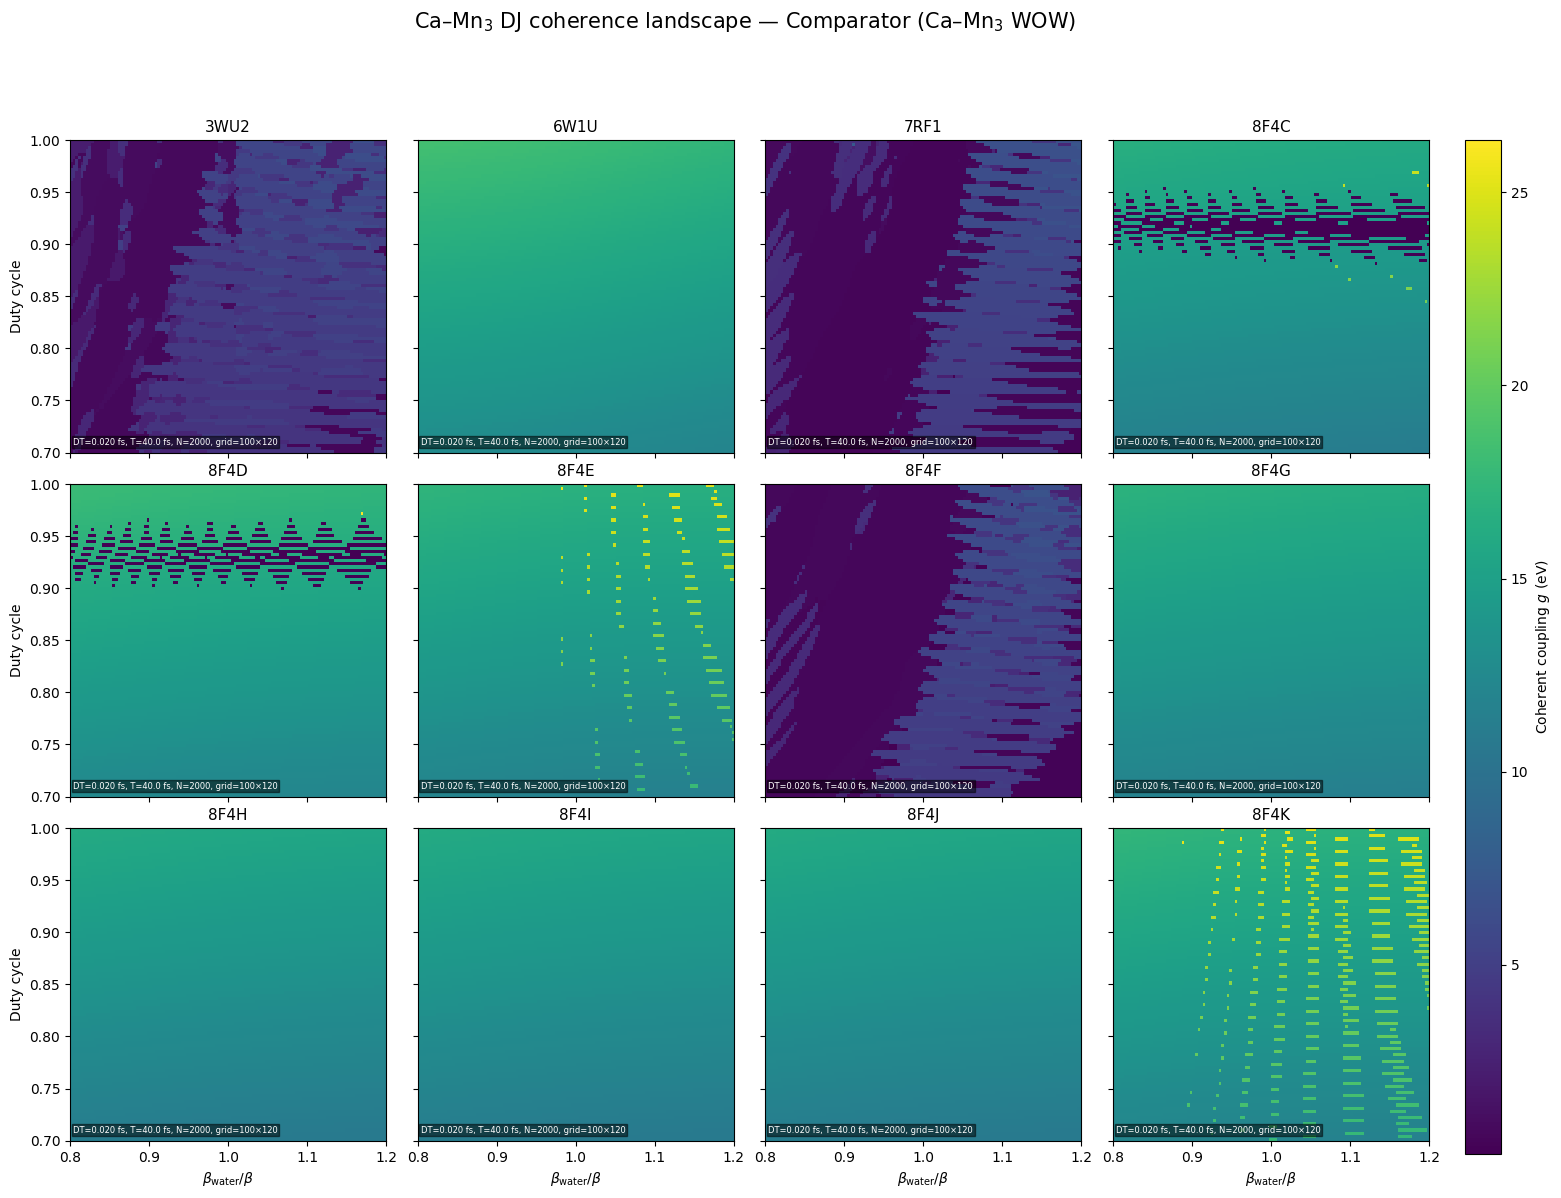

[INFO] Saved comparator 3×4 figure to /content/oec_qge_two_engines/DJ_3x4_comparator.png and /content/oec_qge_two_engines/DJ_3x4_comparator.pdf


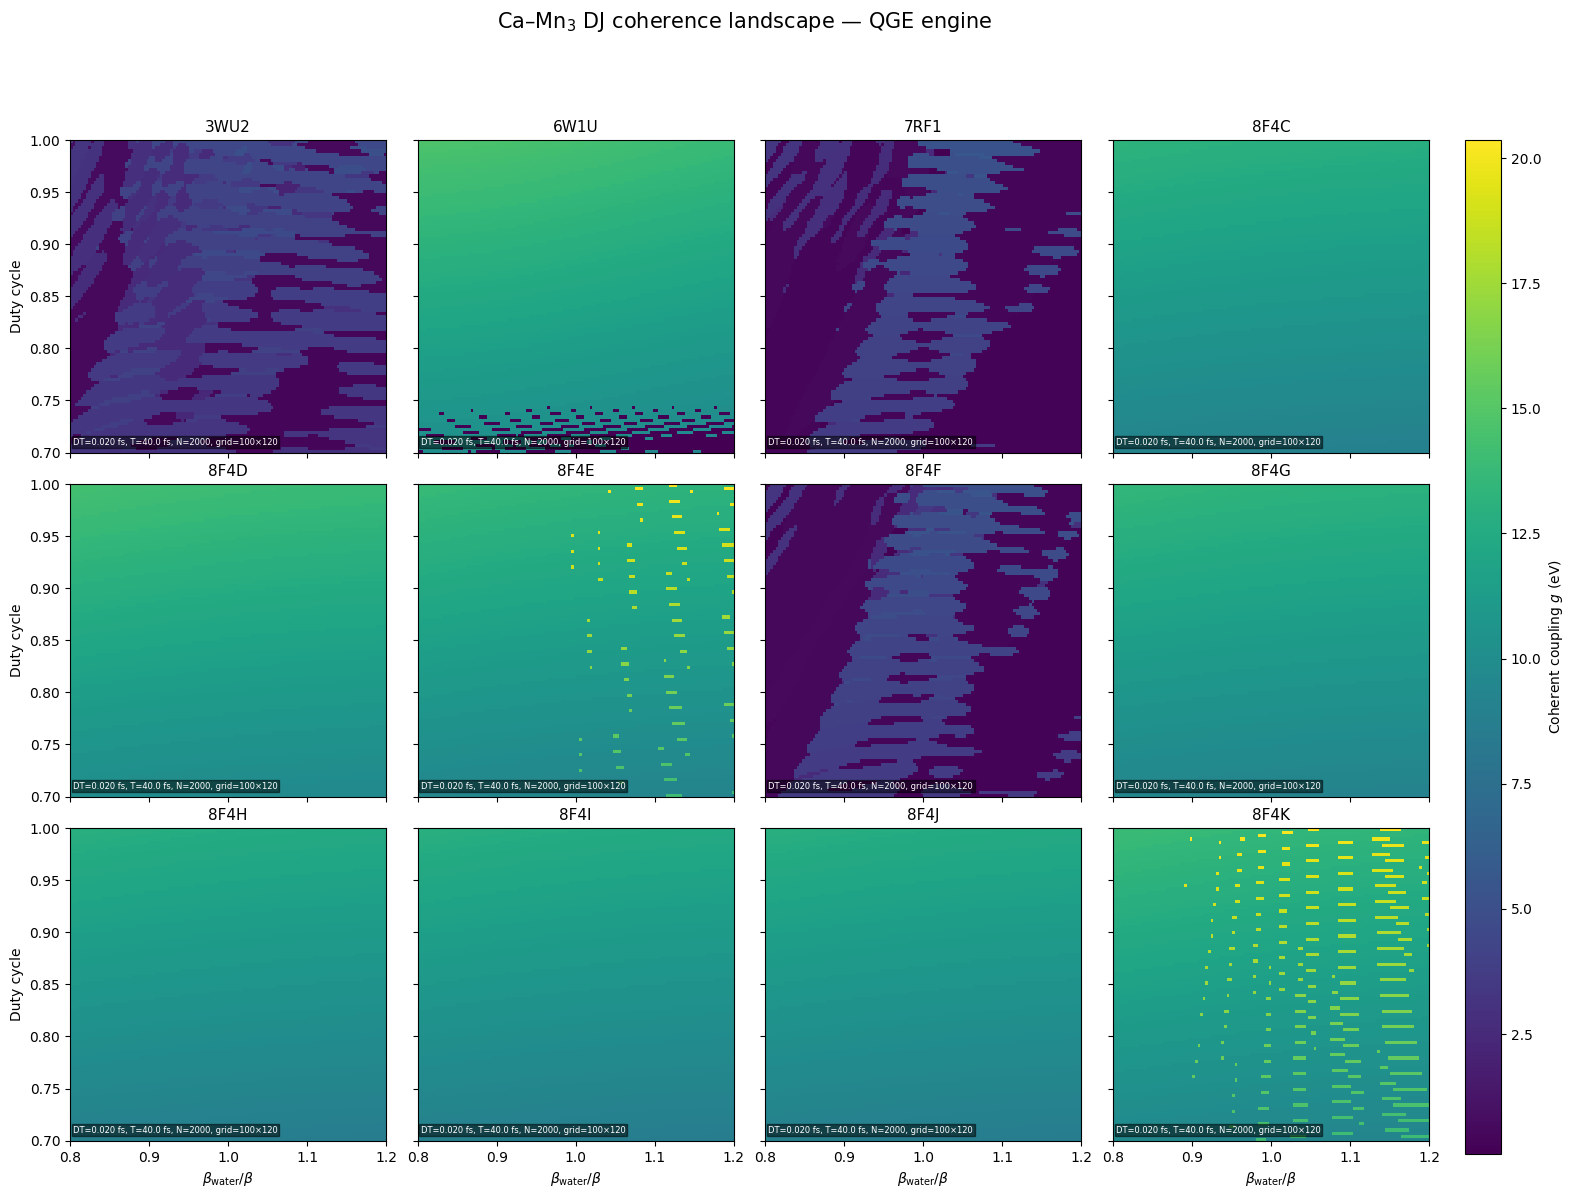

[INFO] Saved qge 3×4 figure to /content/oec_qge_two_engines/DJ_3x4_qge.png and /content/oec_qge_two_engines/DJ_3x4_qge.pdf


In [ ]:
import math  # L001
from pathlib import Path  # L002
import numpy as np  # L003
import gemmi  # L004
from scipy.linalg import expm  # L005
from scipy.optimize import curve_fit  # L006
from scipy.signal import hilbert  # L007
import matplotlib.pyplot as plt  # L008
  # L009
# ---------- GLOBAL CONSTANTS (WOW REGIME PHYSICS) ----------  # L010
H_BAR        = 6.582119569e-16       # eV·s                   # L011
H_BAR_EV_FS  = 6.582119569e-1        # eV·fs (≈0.6582)        # L012
DT_FS        = 0.02                  # fs                     # L013
DT_S         = DT_FS * 1e-15         # seconds                # L014
TOTAL_FS     = 40.0                  # fs                     # L015
N_STEPS      = int(TOTAL_FS / DT_FS)                         # L016
T0           = 10.0                  # comparator coupling    # L017
T0_QGE       = 8.0                   # QGE engine coupling    # L018
BETA_E       = 1.0                   # base decay 1/Å         # L019
COMB_CENTERS = [0.8, 1.1, 1.5, 2.1, 3.4]                     # L020
COMB_WIDTH   = 0.18                  # Å                      # L021
  # L022
# High-res DJ grid                                              # L023
duties = np.linspace(0.70, 1.00, 100)   # duty cycle           # L024
betas  = np.linspace(0.80, 1.20, 120)   # beta_water/beta      # L025
STAMP_TEXT = (                                                  # L026
    f"DT={DT_FS:.3f} fs, T={TOTAL_FS:.1f} fs, "                 # L027
    f"N={N_STEPS}, grid={len(duties)}×{len(betas)}"            # L028
)                                                               # L029
  # L030
# ---------- PATHS / STRUCTURES ------------------------------  # L031
STRUCT_DIR = Path("/content")                                   # L032
OUT_DIR    = Path("/content/oec_qge_two_engines")               # L033
OUT_DIR.mkdir(parents=True, exist_ok=True)                      # L034
  # L035
STRUCTURES = [                                                   # L036
    "3WU2", "6W1U", "7RF1",                                     # L037
    "8F4C", "8F4D", "8F4E", "8F4F",                             # L038
    "8F4G", "8F4H", "8F4I", "8F4J", "8F4K"                      # L039
]                                                               # L040
  # L041
# ---------- GEOMETRY HELPERS (PSII CORE 16) ------------------ # L042
def _atom_iter(struct):  # L043
    for model in struct:  # L044
        for chain in model:  # L045
            for res in chain:  # L046
                for atom in res:  # L047
                    yield model, chain, res, atom  # L048
  # L049
def _combinations(iterable, r):  # L050
    pool = tuple(iterable)  # L051
    n = len(pool)  # L052
    if r > n:  # L053
        return  # L054
    idx = list(range(r))  # L055
    yield tuple(pool[i] for i in idx)  # L056
    while True:  # L057
        for i in reversed(range(r)):  # L058
            if idx[i] != i + n - r:  # L059
                break  # L060
        else:  # L061
            return  # L062
        idx[i] += 1  # L063
        for j in range(i + 1, r):  # L064
            idx[j] = idx[j - 1] + 1  # L065
        yield tuple(pool[i] for i in idx)  # L066
  # L067
def read_structure_any(path: Path):  # L068
    st = gemmi.read_structure(str(path))  # L069
    st.remove_alternative_conformations()  # L070
    st.merge_chain_parts()  # L071
    st.remove_empty_chains()  # L072
    return st  # L073
  # L074
def get_psii_core_16(struct):  # L075
    """Extract the 16-site Mn4CaO5(waters) PSII core used in DJ maps."""  # L076
    mn_atoms, ca_atoms, oxy_atoms, water_oxy = [], [], [], []  # L077
    for _, _, res, atom in _atom_iter(struct):  # L078
        el   = atom.element.name.upper()  # L079
        resn = res.name.upper()  # L080
        pos  = np.array([atom.pos.x, atom.pos.y, atom.pos.z], dtype=float)  # L081
        if el == "MN":  # L082
            mn_atoms.append((pos, res, atom))  # L083
        elif el == "CA":  # L084
            ca_atoms.append((pos, res, atom))  # L085
        elif el == "O":  # L086
            if resn in ("HOH", "WAT", "H2O", "DOD", "TIP3", "SOL"):  # L087
                water_oxy.append((pos, res, atom))  # L088
            else:  # L089
                oxy_atoms.append((pos, res, atom))  # L090
    if len(mn_atoms) < 4 or len(ca_atoms) == 0:  # L091
        raise RuntimeError("Not enough Mn/Ca atoms")  # L092
    mn_positions = np.array([p for (p, _, _) in mn_atoms])  # L093
    best_idx = None  # L094
    best_score = 1e9  # L095
    for idxs in _combinations(range(len(mn_positions)), 4):  # L096
        pts   = mn_positions[list(idxs)]  # L097
        c     = pts.mean(axis=0)  # L098
        score = np.sum(np.linalg.norm(pts - c, axis=1))  # L099
        if score < best_score:  # L100
            best_score = score  # L101
            best_idx   = idxs  # L102
    Mn_sel = [mn_atoms[i] for i in best_idx]  # L103
    Mn_pos = np.array([p for (p, _, _) in Mn_sel])  # L104
    c_mn   = Mn_pos.mean(axis=0)  # L105
    Ca_sel = min(ca_atoms, key=lambda t: np.linalg.norm(t[0] - c_mn))  # L106
    Ca_pos = Ca_sel[0]  # L107
    # μ-oxo O within 2.4 Å of two Mn  # L108
    mu_oxo = []  # L109
    for (pos, res, atom) in oxy_atoms:  # L110
        d = np.linalg.norm(Mn_pos - pos, axis=1)  # L111
        close_mn = np.where(d < 2.4)[0]  # L112
        if len(close_mn) >= 2:  # L113
            mu_oxo.append((pos, res, atom))  # L114
    if len(mu_oxo) < 5:  # L115
        raise RuntimeError("Not enough μ-oxo candidates")  # L116
    mu_oxo.sort(key=lambda t: np.linalg.norm(t[0] - c_mn))  # L117
    OX_sel = mu_oxo[:5]  # L118
    OX_pos = np.array([p for (p, _, _) in OX_sel])  # L119
    # Waters: nearest 2 to Mn4Ca centroid  # L120
    cluster_center = np.vstack([Mn_pos, Ca_pos[None, :]]).mean(axis=0)  # L121
    if len(water_oxy) < 2:  # L122
        raise RuntimeError("Not enough waters")  # L123
    water_oxy.sort(key=lambda t: np.linalg.norm(t[0] - cluster_center))  # L124
    W_sel = water_oxy[:2]  # L125
    W_pos = np.array([p for (p, _, _) in W_sel])  # L126
    coords = np.vstack([Mn_pos, Ca_pos[None, :], OX_pos, W_pos])  # L127
    extra_needed = 16 - coords.shape[0]  # L128
    extras = []  # L129
    others = water_oxy[2:] if len(water_oxy) > 2 else []  # L130
    for i in range(extra_needed):  # L131
        if i < len(others):  # L132
            extras.append(others[i][0])  # L133
        else:  # L134
            extras.append(W_pos[-1] + np.array([0.05 * (i + 1), 0.0, 0.0]))  # L135
    if extras:  # L136
        coords = np.vstack([coords, np.array(extras)])  # L137
    if coords.shape[0] != 16:  # L138
        raise RuntimeError("Core is not 16 sites")  # L139
    labels = (  # L140
        [f"Mn{i+1}" for i in range(4)] +  # L141
        ["Ca"] +  # L142
        [f"muO{i+1}" for i in range(5)] +  # L143
        ["OW3", "OW4"] +  # L144
        [f"OWx{i+1}" for i in range(extra_needed)]  # L145
    )  # L146
    return coords, labels  # L147
  # L148
# ---------- HAMILTONIANS + TDSE ENGINES --------------------- # L149
def resonance_comb(r: float) -> float:  # L150
    val = 0.0  # L151
    for c in COMB_CENTERS:  # L152
        val += math.exp(-(r - c) ** 2 / (2 * COMB_WIDTH ** 2))  # L153
    return 1.0 + 1.5 * (val / (len(COMB_CENTERS) + 1e-9))  # L154
  # L155
def build_hamiltonian_comparator(coords: np.ndarray, duty: float, beta_scale_water: float) -> np.ndarray:  # L156
    """Original Ca–Mn₃ WOW Hamiltonian (comparator engine)."""  # L157
    coords = np.asarray(coords, float)  # L158
    n = coords.shape[0]  # L159
    H = np.zeros((n, n), dtype=np.complex128)  # L160
    diag = np.array([  # L161
        2.0, 2.0, 2.0, 2.0,      # Mn                       # L162
        0.7,                     # Ca                       # L163
        1.0, 1.0, 1.0, 1.0, 1.0, # mu-oxo                   # L164
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2  # waters              # L165
    ], dtype=float)  # L166
    np.fill_diagonal(H, diag)  # L167
    R = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=2)  # L168
    for i in range(n):  # L169
        for j in range(i + 1, n):  # L170
            r = R[i, j]  # L171
            beta = BETA_E  # L172
            if (i >= 10) or (j >= 10):  # L173
                beta = BETA_E * beta_scale_water  # L174
            Tij = T0 * math.exp(-beta * r) * resonance_comb(r) * duty  # L175
            H[i, j] = H[j, i] = Tij  # L176
    return H  # L177
  # L178
def build_hamiltonian_qge(coords: np.ndarray, duty: float, beta_scale_water: float) -> np.ndarray:  # L179
    """  # L180
    QGE engine Hamiltonian.  # L181
    CURRENTLY: slight variant of comparator (different T0, Ca energy).  # L182
    SWAP THIS for your full QGE math when ready.  # L183
    """  # L184
    coords = np.asarray(coords, float)  # L185
    n = coords.shape[0]  # L186
    H = np.zeros((n, n), dtype=np.complex128)  # L187
    diag = np.array([  # L188
        2.0, 2.0, 2.0, 2.0,      # Mn                        # L189
        0.5,                     # Ca (slightly shifted)     # L190
        1.0, 1.0, 1.0, 1.0, 1.0, # mu-oxo                    # L191
        0.3, 0.3, 0.3, 0.3, 0.3, 0.3  # waters (stiffer)     # L192
    ], dtype=float)  # L193
    np.fill_diagonal(H, diag)  # L194
    R = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=2)  # L195
    for i in range(n):  # L196
        for j in range(i + 1, n):  # L197
            r = R[i, j]  # L198
            beta = BETA_E  # L199
            if (i >= 10) or (j >= 10):  # L200
                beta = BETA_E * beta_scale_water  # L201
            Tij = T0_QGE * math.exp(-beta * r) * resonance_comb(r) * duty  # L202
            H[i, j] = H[j, i] = Tij  # L203
    return H  # L204
  # L205
def extract_g_gamma(t_fs, P1, P2, t_min=0.0, t_max=None):  # L206
    t = np.asarray(t_fs)  # L207
    P1 = np.asarray(P1)  # L208
    P2 = np.asarray(P2)  # L209
    if t_max is None:  # L210
        t_max = t[int(0.5 * len(t))]  # L211
    if len(t) < 3:  # L212
        return np.nan, np.nan  # L213
    dP = (P1 - P2)  # L214
    dP = dP - dP.mean()  # L215
    dt = float(t[1] - t[0])  # L216
    freqs = np.fft.rfftfreq(len(t), dt)  # L217
    spec  = np.abs(np.fft.rfft(dP)) ** 2  # L218
    if len(freqs) < 2:  # L219
        return np.nan, np.nan  # L220
    peak_idx = np.argmax(spec[1:]) + 1  # L221
    Omega    = 2.0 * np.pi * freqs[peak_idx]  # L222
    g        = H_BAR_EV_FS * Omega  # L223
    analytic = hilbert(dP)  # L224
    env      = np.abs(analytic)  # L225
    mask    = (t >= t_min) & (t <= t_max)  # L226
    t_fit   = t[mask]  # L227
    env_fit = env[mask]  # L228
    if len(t_fit) < 5:  # L229
        return g, np.nan  # L230
    def model(tt, A, gamma, C):  # L231
        return A * np.exp(-gamma * tt) + C  # L232
    try:  # L233
        A0 = env_fit.max() - env_fit.min()  # L234
        C0 = env_fit.min()  # L235
        g0 = 1.0 / (t_fit[-1] - t_fit[0] + 1e-9)  # L236
        popt, _ = curve_fit(model, t_fit, env_fit, p0=[A0, g0, C0], maxfev=10000)  # L237
        gamma_phi = abs(float(popt[1]))  # L238
    except Exception:  # L239
        gamma_phi = np.nan  # L240
    return g, gamma_phi  # L241
  # L242
def _run_tdse_generic(coords, labels, duty, beta_scale_water, ham_builder) -> tuple:  # L243
    H = ham_builder(coords, duty, beta_scale_water)  # L244
    n = H.shape[0]  # L245
    psi = np.zeros(n, dtype=np.complex128)  # L246
    psi[0] = 1.0  # initial excitation Mn1  # L247
    t_axis_fs = np.arange(N_STEPS) * DT_FS  # L248
    try:  # L249
        idx_Ca = labels.index("Ca")  # L250
        idx_Mn = labels.index("Mn3")  # L251
    except ValueError:  # L252
        raise RuntimeError("Missing Ca/Mn3 labels")  # L253
    P_Ca = np.zeros(N_STEPS, dtype=float)  # L254
    P_Mn = np.zeros(N_STEPS, dtype=float)  # L255
    U = expm(-1j * H * (DT_S / H_BAR))  # L256
    for k in range(N_STEPS):  # L257
        p = np.abs(psi) ** 2  # L258
        P_Ca[k] = p[idx_Ca]  # L259
        P_Mn[k] = p[idx_Mn]  # L260
        psi = U @ psi  # L261
        psi /= np.linalg.norm(psi)  # L262
    g, gamma_phi = extract_g_gamma(t_axis_fs, P_Ca, P_Mn, t_min=0.0, t_max=min(20.0, float(t_axis_fs[-1])))  # L263
    return g, gamma_phi  # L264
  # L265
def run_tdse_camn(coords, labels, duty, beta_scale_water):  # L266
    """Comparator engine (original Ca–Mn3)."""  # L267
    return _run_tdse_generic(coords, labels, duty, beta_scale_water, build_hamiltonian_comparator)  # L268
  # L269
def run_tdse_qge(coords, labels, duty, beta_scale_water):  # L270
    """QGE engine (variant Hamiltonian)."""  # L271
    return _run_tdse_generic(coords, labels, duty, beta_scale_water, build_hamiltonian_qge)  # L272
  # L273
# ---------- DJ MAP METRICS FOR BOTH ENGINES ----------------- # L274
def compute_dj_metrics_for_engine(coords, labels, engine_name: str):  # L275
    """Build DJ map over (duty, beta) for a chosen engine and summarise scalars."""  # L276
    g_grid = np.zeros((len(duties), len(betas)), dtype=float)  # L277
    if engine_name == "comparator":  # L278
        runner = run_tdse_camn  # L279
        prefix = "djA_"  # L280
    elif engine_name == "qge":  # L281
        runner = run_tdse_qge  # L282
        prefix = "djB_"  # L283
    else:  # L284
        raise ValueError("engine_name must be 'comparator' or 'qge'")  # L285
    for i, duty in enumerate(duties):  # L286
        for j, beta_scale in enumerate(betas):  # L287
            g_val, _ = runner(coords, labels, duty, beta_scale)  # L288
            g_grid[i, j] = g_val  # L289
    dj_g_mean = float(np.nanmean(g_grid))  # L290
    dj_g_std  = float(np.nanstd(g_grid))  # L291
    dj_g_max  = float(np.nanmax(g_grid))  # L292
    max_idx   = np.unravel_index(np.nanargmax(g_grid), g_grid.shape)  # L293
    dj_g_max_duty = float(duties[max_idx[0]])  # L294
    dj_g_max_beta = float(betas[max_idx[1]])  # L295
    i_nom = int(np.argmin(np.abs(duties - 0.90)))  # L296
    j_nom = int(np.argmin(np.abs(betas - 1.00)))  # L297
    dj_g_nominal = float(g_grid[i_nom, j_nom])  # L298
    return {  # L299
        prefix + "g_mean": dj_g_mean,  # L300
        prefix + "g_std": dj_g_std,  # L301
        prefix + "g_max": dj_g_max,  # L302
        prefix + "g_max_duty": dj_g_max_duty,  # L303
        prefix + "g_max_beta": dj_g_max_beta,  # L304
        prefix + "g_nominal": dj_g_nominal,  # L305
        prefix + "g_grid": g_grid,  # L306
    }  # L307
  # L308
# ---------- SIMPLE GEOMETRY METRICS (GQR / QGE) ------------- # L309
def geom_metrics(coords: np.ndarray) -> dict:  # L310
    coords = np.asarray(coords, dtype=np.float32)  # L311
    if coords.size == 0:  # L312
        return {}  # L313
    centroid = coords.mean(axis=0)  # L314
    radii = np.linalg.norm(coords - centroid, axis=1)  # L315
    diffs = coords[:, None, :] - coords[None, :, :]  # L316
    dists = np.linalg.norm(diffs, axis=-1)  # L317
    upper = dists[np.triu_indices_from(dists, k=1)]  # L318
    pair_mean = float(upper.mean())  # L319
    pair_std  = float(upper.std())  # L320
    pair_min  = float(upper.min())  # L321
    pair_max  = float(upper.max())  # L322
    dispersion = pair_std / (pair_mean + 1e-9)  # L323
    curvature_index = float(radii.std() / (radii.mean() + 1e-9))  # L324
    m = radii.mean()  # L325
    s = radii.std() + 1e-9  # L326
    skew = float(((radii - m) ** 3).mean() / (s ** 3))  # L327
    median_sep = float(np.median(upper))  # L328
    casimir_gap = median_sep - pair_min  # L329
    return {  # L330
        "n_atoms": int(coords.shape[0]),  # L331
        "radius_mean": float(radii.mean()),  # L332
        "radius_std": float(radii.std()),  # L333
        "radius_max": float(radii.max()),  # L334
        "gqr_pair_mean": pair_mean,  # L335
        "gqr_pair_std": pair_std,  # L336
        "gqr_pair_min": pair_min,  # L337
        "gqr_pair_max": pair_max,  # L338
        "gqr_dispersion": dispersion,  # L339
        "qge_curvature_index": curvature_index,  # L340
        "qge_casimir_gap": casimir_gap,  # L341
        "qge_radial_skew": skew,  # L342
    }  # L343
  # L344
# ---------- EQUIVALENCE HARNESS ----------------------------- # L345
def analyse_single_oec(struct_name: str) -> dict:  # L346
    rec = {"structure": struct_name}  # L347
    cif_path = STRUCT_DIR / f"{struct_name}.cif"  # L348
    if not cif_path.exists():  # L349
        rec["error"] = "cif_not_found"  # L350
        return rec  # L351
    try:  # L352
        st = read_structure_any(cif_path)  # L353
    except Exception as e:  # L354
        rec["error"] = f"load_failed: {e}"  # L355
        return rec  # L356
    try:  # L357
        coords, labels = get_psii_core_16(st)  # L358
    except Exception as e:  # L359
        rec["error"] = f"core16_failed: {e}"  # L360
        return rec  # L361
    rec.update(geom_metrics(coords))  # L362
    djA = compute_dj_metrics_for_engine(coords, labels, "comparator")  # L363
    djB = compute_dj_metrics_for_engine(coords, labels, "qge")  # L364
    g_gridA = djA.pop("djA_g_grid")  # L365
    g_gridB = djB.pop("djB_g_grid")  # L366
    rec.update(djA)  # L367
    rec.update(djB)  # L368
    npz_path = OUT_DIR / f"DJ_{struct_name}_two_engines.npz"  # L369
    np.savez(npz_path, g_grid_comparator=g_gridA, g_grid_qge=g_gridB,
             duties=duties, betas=betas)  # L370
    rec["dj_npz"] = str(npz_path)  # L371
    return rec  # L372
  # L373
def run_oec_benchmark(struct_names=None):  # L374
    import pandas as pd  # L375
    if struct_names is None:  # L376
        struct_names = STRUCTURES  # L377
    records = []  # L378
    for name in struct_names:  # L379
        print(f"\n[INFO] Analysing {name} ...")  # L380
        rec = analyse_single_oec(name)  # L381
        records.append(rec)  # L382
        if "error" in rec:  # L383
            print(f"  -> ERROR: {rec['error']}")  # L384
        else:  # L385
            print(f"  -> djA_g_mean={rec['djA_g_mean']:.4e}, djB_g_mean={rec['djB_g_mean']:.4e}")  # L386
    df = pd.DataFrame.from_records(records)  # L387
    csv_path = OUT_DIR / "oec_two_engine_benchmark.csv"  # L388
    df.to_csv(csv_path, index=False)  # L389
    print(f"\n[INFO] Saved benchmark CSV to: {csv_path}")  # L390
    return df  # L391
  # L392
# ---------- 3×4 PLOTTING FOR BOTH ENGINES ------------------- # L393
def plot_3x4_from_npz(engine: str = "comparator"):  # L394
    """engine='comparator' or 'qge'."""  # L395
    if engine not in ("comparator", "qge"):  # L396
        raise ValueError("engine must be 'comparator' or 'qge'")  # L397
    grids = {}  # L398
    g_min, g_max = np.inf, -np.inf  # L399
    for s in STRUCTURES:  # L400
        npz_path = OUT_DIR / f"DJ_{s}_two_engines.npz"  # L401
        if not npz_path.exists():  # L402
            continue  # L403
        data = np.load(npz_path)  # L404
        key = "g_grid_comparator" if engine == "comparator" else "g_grid_qge"  # L405
        g_grid = data[key]  # L406
        grids[s] = g_grid  # L407
        g_min = min(g_min, np.nanmin(g_grid))  # L408
        g_max = max(g_max, np.nanmax(g_grid))  # L409
    n_structs = len(STRUCTURES)  # L410
    n_rows, n_cols = 3, 4  # L411
    assert n_rows * n_cols == n_structs  # L412
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 13), sharex=True, sharey=True)  # L413
    fig.subplots_adjust(right=0.88, wspace=0.10, hspace=0.10)  # L414
    extent = [betas[0], betas[-1], duties[0], duties[-1]]  # L415
    for idx, struct in enumerate(STRUCTURES):  # L416
        r = idx // n_cols  # L417
        c = idx % n_cols  # L418
        ax = axes[r, c]  # L419
        if struct not in grids:  # L420
            ax.axis("off")  # L421
            continue  # L422
        g_grid = grids[struct]  # L423
        im = ax.imshow(g_grid, origin="lower", extent=extent,
                       aspect="auto", interpolation="nearest",
                       vmin=g_min, vmax=g_max)  # L424
        ax.set_title(struct, fontsize=11)  # L425
        ax.text(0.01, 0.02, STAMP_TEXT, transform=ax.transAxes,
                fontsize=6, color="white", ha="left", va="bottom",
                bbox=dict(facecolor="black", alpha=0.5, pad=1))  # L426
        if r == n_rows - 1:  # L427
            ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")  # L428
        if c == 0:  # L429
            ax.set_ylabel("Duty cycle")  # L430
    cbar_ax = fig.add_axes([0.90, 0.10, 0.02, 0.78])  # L431
    cb = fig.colorbar(im, cax=cbar_ax)  # L432
    cb.set_label(r"Coherent coupling $g$ (eV)")  # L433
    title_engine = "Comparator (Ca–Mn$_3$ WOW)" if engine == "comparator" else "QGE engine"  # L434
    fig.suptitle(f"Ca–Mn$_3$ DJ coherence landscape — {title_engine}", fontsize=15)  # L435
    out_png = OUT_DIR / f"DJ_3x4_{engine}.png"  # L436
    out_pdf = OUT_DIR / f"DJ_3x4_{engine}.pdf"  # L437
    fig.savefig(out_png, dpi=600)  # L438
    fig.savefig(out_pdf)  # L439
    plt.show()  # L440
    plt.close(fig)  # L441
    print(f"[INFO] Saved {engine} 3×4 figure to {out_png} and {out_pdf}")  # L442
  # L443
if __name__ == "__main__":  # L444
    df = run_oec_benchmark()  # L445
    print(df.head())  # L446
    plot_3x4_from_npz(engine="comparator")  # L447
    plot_3x4_from_npz(engine="qge")  # L448

In [ ]:
!pip install gemmi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 30.2 MB/s eta 0:00:00


In [ ]:
import numpy as np  # L001
import matplotlib.pyplot as plt  # L002
from scipy.ndimage import gaussian_filter  # L003
from pathlib import Path  # L004

# ---------- CONFIG ----------  # L005
# Point this to where your DJ_*_two_engines.npz live in Colab  # L006
NPZ_DIR = Path("/content")  # e.g. "/content" or "/content/drive/MyDrive/dj_npz"  # L007

# List the structures you want to plot  # L008
STRUCTS = ["8F4E", "8F4F", "8F4G", "8F4H"]  # L009

# ---------- HELPERS ----------  # L010
def load_two_engine_npz(struct_name: str):  # L011
    npz_path = NPZ_DIR / f"DJ_{struct_name}_two_engines.npz"  # L012
    data = np.load(npz_path)  # L013
    gA = data["g_grid_comparator"]  # L014
    gB = data["g_grid_qge"]         # L015
    duties = data["duties"]         # L016
    betas  = data["betas"]          # L017
    extent = [betas[0], betas[-1], duties[0], duties[-1]]  # L018
    return gA, gB, duties, betas, extent, npz_path  # L019

def vortex_field(g: np.ndarray, sigma: float = 1.0) -> np.ndarray:  # L020
    gy, gx = np.gradient(g)  # L021
    gxx, _ = np.gradient(gx)  # L022
    _, gyy = np.gradient(gy)  # L023
    lap = gxx + gyy  # L024
    v = np.abs(lap)  # L025
    return gaussian_filter(v, sigma)  # L026

def vortex_mask(g: np.ndarray, sigma: float = 1.0, q: float = 0.97):  # L027
    v = vortex_field(g, sigma=sigma)  # L028
    thr = np.quantile(v, q)  # L029
    return v, (v >= thr)  # L030

def plot_g(g, duties, betas, extent, title):  # L031
    fig, ax = plt.subplots(figsize=(5, 5))  # L032
    im = ax.imshow(g, origin="lower", extent=extent, aspect="auto", interpolation="nearest")  # L033
    ax.set_title(title)  # L034
    ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")  # L035
    ax.set_ylabel("Duty cycle")  # L036
    c = fig.colorbar(im, ax=ax)  # L037
    c.set_label("Coherent coupling $g$ (eV)")  # L038
    plt.tight_layout()  # L039
    plt.show()  # L040

def plot_g_with_vortices(g, mask, duties, betas, extent, title):  # L041
    fig, ax = plt.subplots(figsize=(5, 5))  # L042
    im = ax.imshow(g, origin="lower", extent=extent, aspect="auto", interpolation="nearest")  # L043
    yy, xx = np.meshgrid(duties, betas, indexing="ij")  # L044
    ax.contour(xx, yy, mask, levels=[0.5], colors="white", linewidths=0.7)  # L045
    ax.set_title(title)  # L046
    ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")  # L047
    ax.set_ylabel("Duty cycle")  # L048
    c = fig.colorbar(im, ax=ax)  # L049
    c.set_label("Coherent coupling $g$ (eV)")  # L050
    plt.tight_layout()  # L051
    plt.show()  # L052

def plot_vortex_heatmap(v, duties, betas, extent, title):  # L053
    fig, ax = plt.subplots(figsize=(5, 5))  # L054
    im = ax.imshow(v, origin="lower", extent=extent, aspect="auto", interpolation="nearest")  # L055
    ax.set_title(title)  # L056
    ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")  # L057
    ax.set_ylabel("Duty cycle")  # L058
    c = fig.colorbar(im, ax=ax)  # L059
    c.set_label(r"$|\nabla^2 g|$ (arb.)")  # L060
    plt.tight_layout()  # L061
    plt.show()  # L062

# ---------- MAIN LOOP: GENERATE PLOTS FOR EACH STRUCT ----------  # L063
for name in STRUCTS:  # L064
    print(f"\n=== {name} ===")  # L065
    gA, gB, duties, betas, extent, npz_path = load_two_engine_npz(name)  # L066
    print(f"Loaded {npz_path}")  # L067

    # Comparator g  # L068
    plot_g(gA, duties, betas, extent, f"{name} Comparator g")  # L069

    # Comparator + vortices  # L070
    vA, mA = vortex_mask(gA, sigma=1.0, q=0.97)  # L071
    plot_g_with_vortices(gA, mA, duties, betas, extent,
                         f"{name} Comparator g + vortices")  # L072

    # QGE + vortices  # L073
    vB, mB = vortex_mask(gB, sigma=1.0, q=0.97)  # L074
    plot_g_with_vortices(gB, mB, duties, betas, extent,
                         f"{name} QGE g + vortices")  # L075

    # Vortex heatmaps (optional)  # L076
    plot_vortex_heatmap(vA, duties, betas, extent,
                        f"{name} Comparator vortex field |∇²g|")  # L077
    plot_vortex_heatmap(vB, duties, betas, extent,
                        f"{name} QGE vortex field |∇²g|")  # L078

In [ ]:
import shutil

# FOLDER YOU WANT TO ZIP:
folder_to_zip = "/content/oec_qge_two_engines"       # or "/content/dj_maps" etc.

# NAME OF THE OUTPUT ZIP:
zip_output_path = "/content/all_outputs.zip"

# CREATE THE ZIP ARCHIVE:
shutil.make_archive(zip_output_path.replace(".zip",""), 'zip', folder_to_zip)

zip_output_path

'/content/all_outputs.zip'